In [1]:
# Extractive QA : 책에서 문제의 답을 찾는다
# 각 단어의 답의 시작일 확률 계산 start_logits
# 각 단어의 답의 끝일 확률 계산 end_logits
# 가장 확률이 높은 구간 선택 argmax

# Extractive QA 시각화
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import matplotlib.pyplot as plt
import numpy as np


c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 모델 로드
MODEL_NAME = "distilbert-base-uncased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)


c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\31799\.cache\huggingface\hub\models--distilbert-base-uncased-distilled-squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
question = "What is the capital of France?"
context = "Paris is the capital and largest city of France. The city has a population of 2.1 million."


In [4]:
# 토크나이젱션
inputs = tokenizer(question, context, return_tensors="pt")

In [5]:
tokenizer.decode(inputs["input_ids"][0])

'[CLS] what is the capital of france? [SEP] paris is the capital and largest city of france. the city has a population of 2. 1 million. [SEP]'

In [9]:
# 토큰 리스트
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
tokens

['[CLS]',
 'what',
 'is',
 'the',
 'capital',
 'of',
 'france',
 '?',
 '[SEP]',
 'paris',
 'is',
 'the',
 'capital',
 'and',
 'largest',
 'city',
 'of',
 'france',
 '.',
 'the',
 'city',
 'has',
 'a',
 'population',
 'of',
 '2',
 '.',
 '1',
 'million',
 '.',
 '[SEP]']

In [10]:
# 예측
with torch.no_grad():
    outputs = model(**inputs)
outputs

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-4.4885, -1.4051, -5.8661, -5.2205, -5.6770, -6.7631, -4.6283, -6.7033,
         -5.7531,  8.6049, -2.9160, -1.3796, -1.3157, -5.1340, -2.6587, -3.5851,
         -5.5331, -1.0407, -3.4785, -2.4015, -2.9335, -5.4820, -4.7583, -4.0071,
         -6.8392, -3.2206, -6.3824, -5.4599, -4.9034, -5.0824, -5.7532]]), end_logits=tensor([[-1.1698, -1.3085, -4.7093, -5.3567, -4.7161, -6.1060, -2.6509, -5.5727,
         -1.5790,  8.1284,  0.0558, -2.3649, -0.2036, -4.7545, -3.0464, -0.2561,
         -4.2421,  3.0875,  0.8551, -4.7300, -2.0851, -5.7749, -5.7833, -4.0015,
         -6.4753, -4.7162, -5.6991, -4.6643, -2.2221, -1.5829, -1.5789]]), hidden_states=None, attentions=None)

In [13]:
# logits를 확률로 변환
start_probs = torch.softmax(outputs.start_logits, dim=-1)
end_probs = torch.softmax(outputs.end_logits, dim=-1)
# 답변추출
answer_start = torch.argmax(start_probs)
answer_end = torch.argmax(end_probs)
answer_tokens = tokens[answer_start : answer_end]
answer = tokenizer.convert_tokens_to_string(answer_tokens)

print(f'모델의 답변: "{answer}"')
print(f'시작위치 : {answer_start}, 토큰 : {tokens[answer_start]}')
print(f'끝위치 : {answer_end}, 토큰 : {tokens[answer_end]}')
print(f'신뢰도 : {start_probs[0][answer_start].item():.4f}, {end_probs[0][answer_end].item():.4f}')


모델의 답변: ""
시작위치 : 9, 토큰 : paris
끝위치 : 9, 토큰 : paris
신뢰도 : 0.9997, 0.9916


In [16]:
# 상위 5개 후보 출력
# 시작위치 상위 5개
top_start = start_probs.sort(descending=True).indices[0][:5]
for idx in top_start:
    print(f'시작  위치 {idx}  토큰 {tokens[idx]}  확률 {start_probs[0][idx].item():.4f}')
# 종료  위치 상위 5개
top_end = end_probs.sort(descending=True).indices[0][:5]
for idx in top_end:
    print(f'종료  위치 {idx}  토큰 {tokens[idx]}  확률 {end_probs[0][idx].item():.4f}')

시작  위치 9  토큰 paris  확률 0.9997
시작  위치 17  토큰 france  확률 0.0001
시작  위치 12  토큰 capital  확률 0.0000
시작  위치 11  토큰 the  확률 0.0000
시작  위치 1  토큰 what  확률 0.0000
종료  위치 9  토큰 paris  확률 0.9916
종료  위치 17  토큰 france  확률 0.0064
종료  위치 18  토큰 .  확률 0.0007
종료  위치 10  토큰 is  확률 0.0003
종료  위치 12  토큰 capital  확률 0.0002


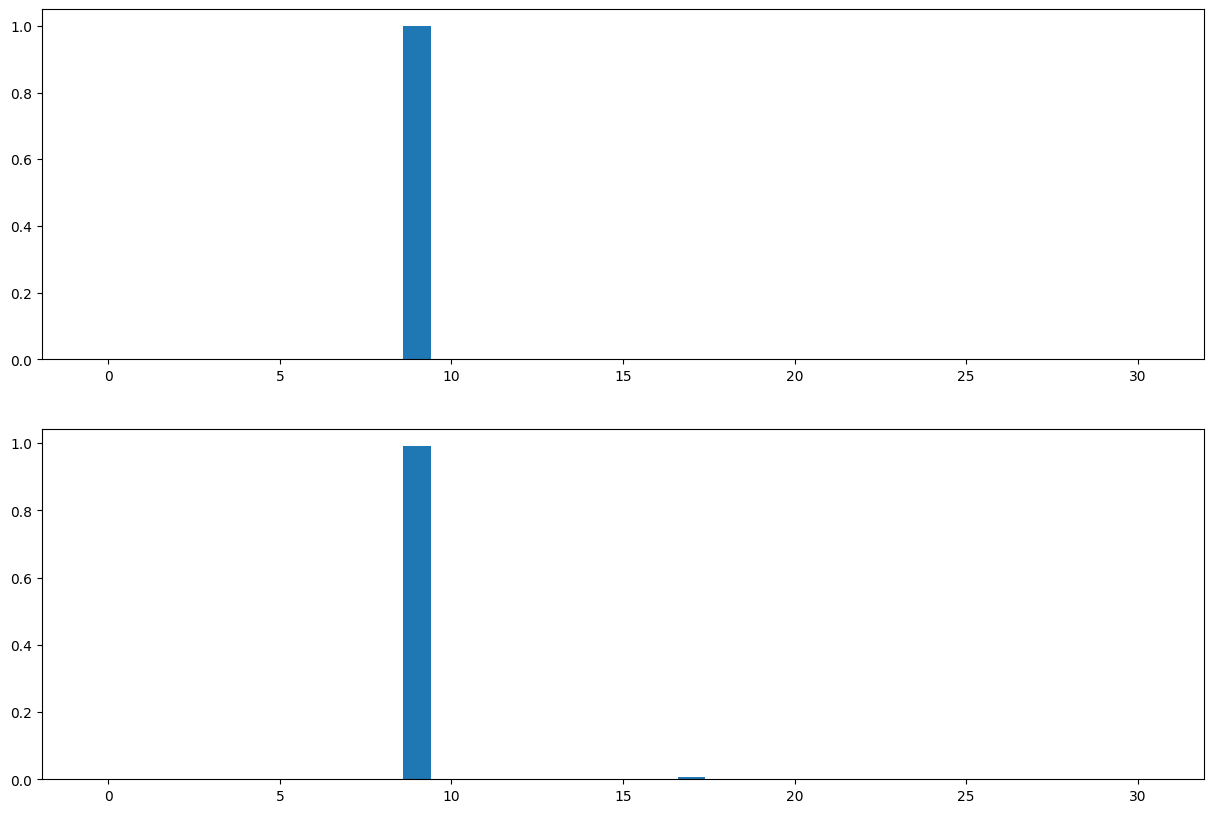

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.bar(np.arange(len(tokens)), start_probs[0])
ax2.bar(np.arange(len(tokens)), end_probs[0])
plt.show()

In [ ]:
# 결론 : 확률이 고르게 분산 -> 답을 못찾은 경우, 특정 구간에 집중되면 확신있는 답을 찾음


offset matting : 토큰단위로 찾다보면 단어가 분리되어서 자연스럽지 못하기 때문에 문자위치로 변환하는 과정을 거쳐야 자연스러운 문장이 나온다

In [21]:
'''
문맥 : paris is the capital of france.
       01234567890  <- 문자 인덱스
토큰 : [paris] [is] [the] [capital] [of] [france] [. ]
       0       1     2      3        4      5     6   <- 토큰 인덱스
'''
# 모델은 토큰인덱스로 작동(3번 토큰 'capital' ~ 5번 토큰 'france')
# 답변위치는 문자인덱스 (13번째 문자부터 'capital' ~ 24번째 문자 'france')
offset_mapping = [
    (0, 5),   # 'paris'
    (6, 8),   # 'is'
    (9, 12),  # 'the'
    (13, 20), # 'capital'
    (21, 23), # 'of'
    (24, 30), # 'france'
    (30, 31)  # '.'
]
# 활용
# 문자위치 -> 토큰위치 : Fine-tuning 시 답변 레이블 생성
# 토큰위치 -> 문자위치 : 예측 결과를 원문에 매칭

In [25]:
# 토큰위치 <-> 문자위치 변환 함수
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
question = "What is AI?"
context = "Artificial Intelligence (AI) is the simulation of human intelligence in machines."
inputs = tokenizer(
    question,
    context,
    return_offsets_mapping=True,
    truncation=True,
)

# 토큰리스트
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"])
offset_mapping = inputs["offset_mapping"]
# 전체 텍스트(질문 + 문맥)
full_text = question + context
# 토큰별 위치 매핑
print(f"{'인덱스':<8}{'토큰':<15}{'문자위치':<15}{'문자열':<20}")


인덱스     토큰             문자위치           문자열                 


In [26]:
for idx, (token, (start, end)) in enumerate(zip(tokens, offset_mapping)):
        if start == end == 0:  # 특수 토큰
            matched_text = "[특수 토큰]"
            position = "N/A"
        else:
            # 원래 텍스트에서 추출
            matched_text = full_text[start:end]
            position = f"({start:3d}, {end:3d})"
        
        # 답변 영역 하이라이트
        highlight = "" if "AI" in token or "Intelligence" in token else "  "
        print(f"{idx:<8} {token:<25} {position:<18} '{matched_text}' {highlight}")

0        [CLS]                     N/A                '[특수 토큰]'   
1        what                      (  0,   4)         'What'   
2        is                        (  5,   7)         'is'   
3        ai                        (  8,  10)         'AI'   
4        ?                         ( 10,  11)         '?'   
5        [SEP]                     N/A                '[특수 토큰]'   
6        artificial                (  0,  10)         'What is AI'   
7        intelligence              ( 11,  23)         'Artificial I'   
8        (                         ( 24,  25)         't'   
9        ai                        ( 25,  27)         'el'   
10       )                         ( 27,  28)         'l'   
11       is                        ( 29,  31)         'ge'   
12       the                       ( 32,  35)         'ce '   
13       simulation                ( 36,  46)         'AI) is the'   
14       of                        ( 47,  49)         'si'   
15       human                    

In [28]:
# 실제 답변 우치
answer = 'Artificial Intelligence'
# 문맥에서 답변의 문자 위치 찾기
answer_start_char = context.index(answer)
answer_end_char = answer_start_char + len(answer)
# 문자위치 -> 토큰위치 변환
answer_start_token = None
answer_end_token = None
# 질문 부분 건너뛰기 (sequence_id 이용)
sequence_id = inputs.sequence_ids(0)
context_start_idx = sequence_id.index(1)
# 문맥에서 절대 위치를 계산하기 위해 질문 길이 보정
question_length = len(question)+1
abs_answer_start = answer_start_char + question_length
abs_answer_end = answer_end_char + question_length
print(f'질문 길이 보정 + ({question_length}) -> 절대 위치 {abs_answer_start} ~ {abs_answer_end}')

질문 길이 보정 + (12) -> 절대 위치 12 ~ 35


In [39]:
for idx in range(context_start_idx, len(offset_mapping)):
  start, end = offset_mapping[idx]

  if start == end == 0:  # 특수 토큰 무시
      continue

  # 답변 시작 토큰 찾기
  if answer_start_token is None and end > abs_answer_start:
      answer_start_token = idx
      print(f"    시작 토큰 발견!")
      print(f"     인덱스: {idx}")
      print(f"     토큰: '{tokens[idx]}'")
      print(f"     오프셋: ({start}, {end})")
      print()

  # 답변 종료 토큰 찾기
  if answer_end_token is None and start >= abs_answer_end:
      answer_end_token = idx - 1
      print(f"    종료 토큰 발견!")
      print(f"      인덱스: {idx - 1}")
      print(f"      토큰: '{tokens[idx-1]}'")
      print(f"      오프셋: {offset_mapping[idx-1]}")
      break

print("\n" + "="*80)
print("최종 결과")
print("="*80)

if answer_start_token and answer_end_token:
    print(f"\n 변환 성공!")
    print(f"   토큰 위치: {answer_start_token} ~ {answer_end_token}")
    print(f"   토큰 리스트: {tokens[answer_start_token:answer_end_token+1]}")

    # 역변환 확인
    reconstructed = tokenizer.convert_tokens_to_string(
        tokens[answer_start_token:answer_end_token+1]
    )
    print(f"   복원된 텍스트: '{reconstructed}'")
    print(f"   원본 텍스트: '{answer}'")

    if answer.lower() in reconstructed.lower():
        print(f"\n   검증 성공! 완벽하게 매칭됩니다.")
    else:
        print(f"\n   부분 일치 (토크나이제이션으로 인한 차이)")
else:
    print("\n 변환 실패 - 답변을 찾을 수 없습니다")
    
    
    #  Offset Mapping이란?
    #    각 토큰이 원본 텍스트의 어느 위치에 해당하는지 기록
       
    #  형식:
    #    [(start_char, end_char), ...]
    #    - start_char: 토큰 시작 문자 위치
    #    - end_char: 토큰 종료 문자 위치 (exclusive)
       
    # 변환 방법:
    #    1. 문자 위치 → 토큰 위치
    #       - offset_mapping을 순회
    #       - 문자 위치가 offset 범위 내에 있는 토큰 찾기
          
    #    2. 토큰 위치 → 문자 위치
    #       - offset_mapping[토큰_인덱스] 직접 참조
          
    # 주의사항:
    #    - 특수 토큰은 (0, 0)으로 표시
    #    - truncation으로 잘린 부분은 offset 없음
    #    - Fine-tuning 시 필수적으로 사용!
       
    # 활용:
    #    - SQuAD 데이터 전처리: 답변 문자 위치 → 토큰 위치
    #    - 예측 결과 해석: 토큰 위치 → 원문 매칭
    #    - 답변 검증: 예측한 토큰이 실제 답변과 일치하는지 확인


최종 결과

 변환 성공!
   토큰 위치: 7 ~ 12
   토큰 리스트: ['intelligence', '(', 'ai', ')', 'is', 'the']
   복원된 텍스트: 'intelligence ( ai ) is the'
   원본 텍스트: 'Artificial Intelligence'

   부분 일치 (토크나이제이션으로 인한 차이)


In [40]:
# SQuAD
'''
{
    'question': 'What is the capital of France?',
    'context': 'Paris is the capital and largest city of France. The city has a population of 2.1 million.',
    'answer': {
        'text': 'Paris',
        'answer_start': 0
    }
}
'''
# 1. 토크나이제이션
# [CLS] when... [SEP] Paris is the capital ... [SEP]

# 2. 답변 문자 위치 확인
answer_start_char = 31
answer_end_char = 36 #(31+len('Paris'))
# 3. sequence_id 이용해 문맥 토큰 시작 인덱스 찾기
context_range =  [10, 45] # 토큰 10번 ~ 토큰 45번
# 4. offset_mapping 이용해 토큰 위치 변환
answer_start_token = 18 # (토큰 18번 'Paris' 시작)
answer_end_token = 19 # (토큰 19번 'Paris' 종료 다음)
# 5. 검증 답변이 문맥 내 --> yes , truncate로 잘리지 않음 -> yes
# 6. 최종 학습데이터 생성
'''
    {
        'input_ids': [...],
        'attention_mask': [...],
        'start_positions': 18,
        'end_positions': 19
    }
'''



"\n    {\n        'input_ids': [...],\n        'attention_mask': [...],\n        'start_positions': 18,\n        'end_positions': 19\n    }\n"

In [42]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# SQuAD 데이터 샘플
sample = {
    "question": "When was the Eiffel Tower built?",
    "context": "The Eiffel Tower was built in 1889 for the Paris World's Fair. It was designed by Gustave Eiffel and remains one of the most iconic structures in the world.",
    "answers": {
        "text": ["1889"],
        "answer_start": [31]  # "1889"의 문자 시작 위치
    }
}

c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\31799\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
